In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256

In [3]:
x_ = list(map(ord, "hello"))    # ascii code로 변환
y_ = list(map(ord, "hola"))
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        outputs = []
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_input, decoder_state = self.decoder(decoder_input, decoder_state)
            
            # 디코더의 출력값으로 다음 글자 예측
            projection = self.project(decoder_input)
            outputs.append(projection)
            
            # teacher forcing 을 이용한 디코더 입력 갱신
            decoder_input = torch.LongTensor([targets[i]])
        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()


 ITER: 0 Loss: 5.708127498626709
['è', 'Z', 'x', '\x8e']

 ITER: 100 Loss: 2.412604331970215
['h', 'o', 'l', 'a']

 ITER: 200 Loss: 0.517680287361145
['h', 'o', 'l', 'a']

 ITER: 300 Loss: 0.2150571644306183
['h', 'o', 'l', 'a']

 ITER: 400 Loss: 0.1277601569890976
['h', 'o', 'l', 'a']

 ITER: 500 Loss: 0.08856824040412903
['h', 'o', 'l', 'a']

 ITER: 600 Loss: 0.06649582087993622
['h', 'o', 'l', 'a']

 ITER: 700 Loss: 0.052372127771377563
['h', 'o', 'l', 'a']

 ITER: 800 Loss: 0.04259730130434036
['h', 'o', 'l', 'a']

 ITER: 900 Loss: 0.03546377271413803
['h', 'o', 'l', 'a']


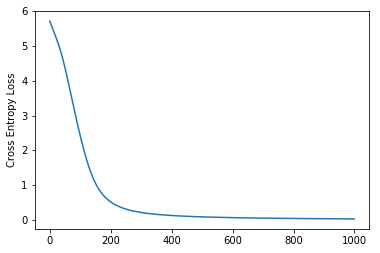

In [5]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n ITER: %d Loss: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])

plt.plot(log)
plt.ylabel("Cross Entropy Loss")
plt.show()